<a href="https://colab.research.google.com/github/maxrinal/nlp-disaster/blob/master/TP2_CODES/DiCaro_97582/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning**

## Importo Librerías

In [ ]:
#! python -m textblob.download_corpora
#!pip install --user -U nltk
#nltk.download('punkt')
#!pip install kaggle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from textblob import TextBlob
from wordcloud import WordCloud
import string,re
import urllib.parse
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk .tokenize.regexp import regexp_tokenize
import spacy
import keras
import html
import re
import urllib
import warnings
import time
import random

from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')

from sklearn.neighbors import KNeighborsClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import lightgbm as lgb

In [ ]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

plt.style.use('default') #Haciendo los gráficos más bonitos en matplotlib

sns.set(style = 'whitegrid') #Seteando tipo de grid en sns

pd.options.display.float_format = '{:20,.2f}'.format #Suprimimos la notacion científica en los outputs

warnings.filterwarnings("ignore")

In [ ]:
print('re version', re.__version__)
print('nltk version', nltk.__version__)
print('spacy version', spacy.__version__)
print('keras version', keras.__version__)

re version 2.2.1
nltk version 3.2.5
spacy version 2.2.4
keras version 2.4.3


## Importo Datos

In [ ]:
train_original = pd.read_csv('https://raw.githubusercontent.com/maxrinal/nlp-disaster/master/train.csv', encoding = 'utf-8')
test_original = pd.read_csv('https://raw.githubusercontent.com/maxrinal/nlp-disaster/master/test.csv', encoding = 'utf-8')

In [ ]:
test_original.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
train = pd.concat([train_original, test_original])[['id', 'keyword', 'location', 'text', 'target']]

In [ ]:
set_train_franco = pd.read_csv('/content/set_train.csv')
set_test_franco = pd.read_csv('/content/set_validation.csv')
set_submit_franco = pd.read_csv('/content/set_test.csv')

train_franco = pd.concat([set_train_franco, set_test_franco, set_submit_franco])
train_franco.drop(columns= ['target'], inplace= True)

print(len(set_train_franco))
print(len(set_test_franco))
print(len(train) == len(train_franco))

train = train_franco.merge(train, left_on= 'id', right_on= 'id', how= 'left')

6090
1523
True


# Limpieza

### Funciones

In [ ]:
caracteres_extraños = ['\u017E', '\u017D', '\u017C', '\u017B', '\u017A', '\u0179', '\u0178', '\u0177', '\u0176', '\u00FF', '\u00FD', '\u00DD', '\u0175',\
                         '\u0174', '\u0173', '\u0172', '\u0171', '\u0170', '\u016F', '\u016E', '\u016D', '\u016C', '\u016B', '\u016A', '\u0169', '\u0168',\
                         '\u00FC', '\u00FB', '\u00FA', '\u00F9', '\u00DC', '\u00DB', '\u00DA', '\u00D9', '\u0167', '\u0166', '\u0165', '\u0164', '\u0163',\
                         '\u0162', '\u017F', '\u0161', '\u0160', '\u015F', '\u015E', '\u015D', '\u015C', '\u015B', '\u015A', '\u0159', '\u0158', '\u0157',\
                         '\u0156', '\u0155', '\u0154', '\u0151', '\u0150', '\u014F', '\u014E', '\u014D', '\u014C', '\u00F8', '\u00F6', '\u00F5', '\u00F4',\
                         '\u00F3', '\u00F2', '\u00D8', '\u00D6', '\u00D5', '\u00D4', '\u00D3', '\u00D2', '\u014B', '\u014A', '\u0149', '\u0148', '\u0147',\
                         '\u0146', '\u0145', '\u0144', '\u0143', '\u00F1', '\u00D1', '\u0142', '\u0141', '\u0140', '\u013F', '\u013E', '\u013D', '\u013C',\
                         '\u013B', '\u013A', '\u0139', '\u0138', '\u0137', '\u0136', '\u0135', '\u0134', '\u0131', '\u0130', '\u012F', '\u012E', '\u012D',\
                         '\u012C', '\u012B', '\u012A', '\u0129', '\u0128', '\u00EF', '\u00EE', '\u00ED', '\u00EC', '\u00CF', '\u00CE', '\u00CD', '\u00CC',\
                         '\u0127', '\u0126', '\u0125', '\u0124', '\u0123', '\u0122', '\u0121', '\u0120', '\u011F', '\u011E', '\u011D', '\u011C', '\u011B',\
                         '\u011A', '\u0119', '\u0118', '\u0117', '\u0116', '\u0115', '\u0114', '\u0113', '\u0112', '\u00EB', '\u00EA', '\u00E9', '\u00E8',\
                         '\u00CB', '\u00CA', '\u00C9', '\u00C8', '\u0111', '\u0110', '\u010F', '\u010E', '\u00F0', '\u00D0', '\u010D', '\u010C', '\u010B',\
                         '\u010A', '\u0109', '\u0108', '\u0107', '\u0106', '\u00E7', '\u00C7', '\u0105', '\u0104', '\u0103', '\u0102', '\u0101', '\u0100',\
                         '\u00E5', '\u00E4', '\u00E3', '\u00E2', '\u00E1', '\u00E0', '\u00C5', '\u00C4', '\u00C3', '\u00C2', '\u00C0', '\u00C1']

monosilabos = ['£', '¤', '¨', '«', '¬', '´', '¡']

words_to_clean = stopwords.words('english')
words_to_clean.append('')

In [ ]:
def remuevo_caracteres_de_lista (texto, lista):
  for caracter in lista:
    texto = texto.replace(caracter, ' ')
  return texto

def clean_texto (texto, caracteres_extraños, monosilabos):
  texto = re.compile(r'https?://\S+|www\.\S+').sub(r'',texto) #Removing urls
  texto = html.unescape(texto)
  texto = urllib.parse.unquote(str(texto))
  texto = re.compile(r'<.*?>').sub(r'',texto) #Removing HTML tags
  texto = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags = re.UNICODE).sub(r'', texto)
  texto = texto.translate(str.maketrans('','',string.punctuation))
  texto = texto.lower()
  texto = texto.translate(str.maketrans('','','1234567890'))
  texto = texto.replace('\n', ' ').replace('å', ' ').replace('ê', ' ').replace('û', ' ').replace('[^\w\s]',' ').replace('÷', ' ').replace('ª', ' ')\
             .replace('ì', ' ').replace('¢', ' ').replace('\x89', ' ').replace('\x9d', ' ').replace('ã', ' ').replace('ï', ' ').replace('©', ' ')\
             .replace('ó', ' ').replace('ò', ' ').replace('â', ' ').replace('\x9b', ' ').replace('\x8a', ' ').replace('\x93', ' ').replace('\x8f', ' ')\
             .replace('\x8c', ' ').replace('¼', ' ').replace('¥', ' ').replace('\x92', ' ').replace('·', ' ').replace('\x82', ' ').replace('Û', ' ')\
             .replace('Ó', ' ').replace('Ê', ' ').replace('Ï', ' ')
  texto = remuevo_caracteres_de_lista(texto, caracteres_extraños)
  texto = remuevo_caracteres_de_lista(texto, monosilabos)
  return texto
                        
def custom_tokenize (notes, caracteres_extraños, monosilabos):
  notes = [clean_texto(texto, caracteres_extraños, monosilabos) for texto in notes]
  tokens = regexp_tokenize(' '.join(notes), pattern = '\s+', gaps = True)
  return tokens

def paso_diccionario_word_frecuencia (lista):
  dic = {}
  for word in lista:
    if word in dic.keys():
      dic[word] += 1
    else:
      dic[word] = 1
  return dic

def saco_palabras_cortas (lista_tokens_frecuencia):
  for i, word in enumerate(lista_tokens_frecuencia):
    if (len(word[0]) < 3):
      lista_tokens_frecuencia.pop(i)
  return lista_tokens_frecuencia

def sumo_listas (lista1, lista2):
  for elemento in lista1:
    if not elemento in lista2:
      lista2.append(elemento)
  return lista2

## Limpieza Location

In [ ]:
train['location'] = train.location.transform(lambda x: html.unescape(x))
train['location'] = train.location.transform(lambda x: urllib.parse.unquote(str(x)))
train['location'] = train.location.transform(lambda x: re.compile(r'<.*?>').sub(r'', x))
train['location'] = train.location.transform(lambda x: x.translate(str.maketrans('','',string.punctuation)))
train['location'] = train.location.transform(lambda x: x.lower())
train['location'] = train.location.transform(lambda x: x.translate(str.maketrans('','','1234567890')))
train['location'] = train.location.transform(lambda x: remuevo_caracteres_de_lista(x, caracteres_extraños))
train['location'] = train.location.transform(lambda x: remuevo_caracteres_de_lista(x, monosilabos))

In [ ]:
labelbinarizer = LabelBinarizer()
X_location = labelbinarizer.fit_transform(train.location)

In [ ]:
np.shape(X_location)

(10876, 4134)

## Limpieza Keyword

In [ ]:
train['keyword'] = train.keyword.transform(lambda x: urllib.parse.unquote(str(x)))
#mlb = MultiLabelBinarizer()
#labelencoder = LabelEncoder()
labelbinarizer = LabelBinarizer()
X_keyword = labelbinarizer.fit_transform(train.keyword)

In [ ]:
np.shape(X_keyword)

(10876, 222)

## Limpieza Texto

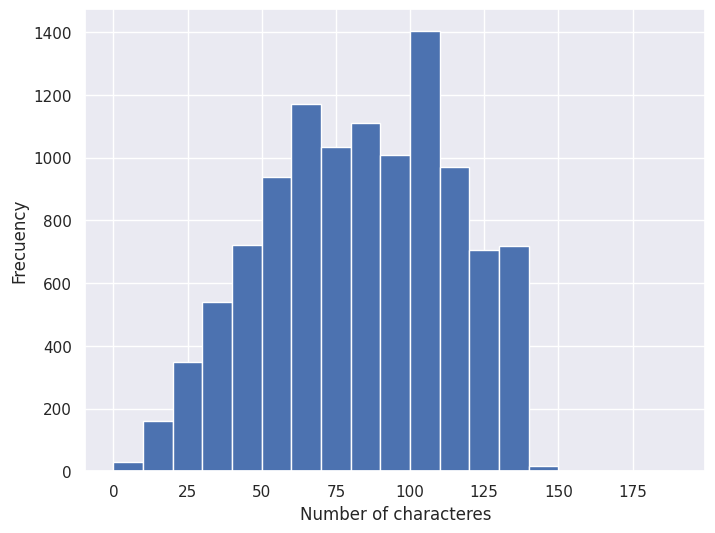

In [ ]:
train['text_len'] = train.text.transform(lambda x: len(clean_texto(x, caracteres_extraños, monosilabos)))

sns.set(font_scale = 1)
plt.figure(figsize = (8, 6))

plt.hist(train.text_len.values, bins = range(0, 200, 10))
plt.xlabel('Number of characteres')
plt.ylabel('Frecuency')
plt.show()

In [ ]:
notes = list(train.text.values)
#random.seed(42)
#random.shuffle(notes)
tokens = custom_tokenize(notes, caracteres_extraños, monosilabos)
palabras_para_sacar = [word for word in tokens if len(word) < 3]
words_to_clean = sumo_listas(palabras_para_sacar, words_to_clean)
#tokens = sorted(tokens)
#dic_tokens = paso_diccionario_word_frecuencia(tokens)
#lista_tokens_frecuencia = list(dic_tokens.items())
#lista_tokens_frecuencia_limpia = saco_palabras_cortas(lista_tokens_frecuencia)
#lista_tokens_frecuencia_limpia = saco_palabras_cortas(lista_tokens_frecuencia_limpia)

In [ ]:
corpus = [clean_texto(texto, caracteres_extraños, monosilabos) for texto in notes]

In [ ]:
vectorizer = CountVectorizer(analyzer = 'word', stop_words = words_to_clean, lowercase = True, strip_accents = 'ascii', ngram_range = (1, 1))
X_texto = vectorizer.fit_transform(corpus)
X_texto_array = X_texto.toarray()

In [ ]:
np.shape(X_texto_array)

(10876, 20645)

# Modelos

In [ ]:
X_text_len = train.text_len.values
X_text_len = np.reshape(X_text_len, (10876, 1))
np.shape(X_text_len)

(10876, 1)

In [ ]:
y = train.target.values
X = X_texto_array
X = np.hstack((X, X_keyword))
#X = np.hstack((X, X_text_len))
X = np.hstack((X, X_location))

In [ ]:
np.shape(y)

(10876,)

In [ ]:
np.shape(X)

(10876, 25001)

In [ ]:
X_fit = X[0:7613]
X_submit = X[7613:]
y_fit = y[0:7613]
y_submit = y[7613:]

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X_fit, y, test_size = 0.2, random_state = 123)
X_train = X_fit[0:6090]
X_test = X_fit[6090:]
y_train = y_fit[0:6090]
y_test = y_fit[6090:]
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(y_test))

(6090, 25001)
(1523, 25001)
(6090,)
(1523,)


# KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'.format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.75
Accuracy of K-NN classifier on test set: 0.71


In [ ]:
knn_pred = knn.predict(X_submit)

In [ ]:
resultados_knn = resultados[['id']]
resultados_knn['target'] = knn_pred

In [ ]:
resultados_knn.to_csv('submission_1_knn.csv', header = True, index = False) 
files.download('submission_1_knn.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>